## AIMI High School Internship 2023
### Notebook 2: Training a Vision Model to Predict ET Distances

**The Problem**: Given a chest X-ray, our goal in this project is to predict the distance from an endotracheal tube to the carina. This is an important clinical task - endotracheal tubes that are positioned too far (>5cm) above the carina will not work effectively.

**Your Second Task**: You should now have a training dataset consisting of (a) chest X-rays and (b) annotations indicating the distance of the endotracheal tube from the carina. Now, your goal is to train a computer vision model to predict endotracheal tube distance from the image. You have **two options** for this task, and you may attempt one or both of these:
- *Distance Categorization* : Train a model to determine whether the position of a tube is abnormal (>5.0 cm) or normal (≤ 5.0 cm).
- *Distance Prediction*: Train a model that predicts the distance of the endotracheal tube from the carina in centimeters.

In this notebook, we provide some simple starter code to get you started on training a computer vision model. You are not required to use this template - feel free to modify as you see fit.

**Submitting Your Model**: We have created a leaderboard where you can submit your model and view results on the held-out test set. We provide instructions below for submitting your model to the leaderboard. **Please follow these directions carefully**.

We will evaluate your results on the held-out test set with the following evaluation metrics:
- *Distance Categorization* : We will measure AUROC, which is a metric commonly used in healthcare tasks. See this blog for a good explanation of AUROC: https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/
- *Distance Prediction*: We will measure the mean average error (also known as L1 distance) between the predicted distances and the true distances.


## Load Data
Before you begin, make sure to go to `Runtime` > `Change Runtime Type` and select a T4 GPU. Then, upload `data.zip`. It should take about 10 minutes for these files to be uploaded. Then, run the following cells to unzip the dataset (which should take < 10 seconds)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq /content/drive/MyDrive/kams_colab/mimic-train.zip

In [3]:
!unzip -qq /content/drive/MyDrive/kams_colab/mimic-test.zip

## Import Libraries
We are leveraging the PyTorch framework to train our models. For more information and tutorials on PyTorch, see this link: https://pytorch.org/tutorials/beginner/basics/intro.html

In [4]:
# Some libraries that you may find useful are included here.
# To import a library that isn't provided with Colab, use the following command: !pip install torchmetrics
import torch
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader, random_split


## Create Dataloaders
We will implement a custom Dataset class to load in data. A custom Dataset class must have three methods: `__init__`, which sets up any class variables, `__len__`, which defines the total number of images, and `__getitem__`, which returns a single image and its paired label.

In [5]:
from torch.utils.data import Dataset
from PIL import Image

device = "cuda:0" if torch.cuda.is_available() else "cpu"

class ChestXRayDataset(Dataset):
    def __init__(self, img_paths, labels, distances):
        super(ChestXRayDataset, self).__init__()
        self.img_paths = img_paths
        self.labels = labels
        self.distances = distances
        # Fill in __init__() here

    def __len__(self):

        # Fill in __len__() here
        return self.labels.shape[0]

    def __getitem__(self, idx):
        out_dict = {"idx": torch.tensor(idx),}

        # Fill in __getitem__() here
        im = Image.open(f"/content/{self.img_paths[idx]}")

        w, h = im.size
        ima = Image.new('RGB', (w,h))
        data = zip(im.getdata(), im.getdata(), im.getdata())
        ima.putdata(list(data))
        convert_tensor = transforms.Compose([
            transforms.Resize(size=224),
            transforms.ToTensor(),
        ])

        img_as_tensor = convert_tensor(ima)
        img_as_tensor.requires_grad_ = True
        out_dict["img"] = img_as_tensor
        out_dict["labels"] = self.labels[idx]
        out_dict["distance"] = self.distances[idx]

        return out_dict
print(device)

cuda:0


## Define Training Components
Here, define any necessary components that you need to train your model, such as the model architecture, the loss function, and the optimizer.

In [6]:
import torch.nn as nn

data = pd.read_csv("/content/drive/MyDrive/kams_colab/mimic_train_labels_pruned.csv")
img_paths = data["image_path"].to_numpy()
labels = data["positioning"].to_numpy()
distances = data["measures"].to_numpy()

dataset = ChestXRayDataset(img_paths=img_paths, labels=labels, distances=distances)

def get_train_val_split(dataset, batch_size=10, train_prop=0.8):
    dataset_length = len(dataset)
    train_length = int(dataset_length * train_prop)
    val_length = dataset_length - train_length
    train_dataset, val_dataset = random_split(
            dataset, [train_length, val_length]
        )

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return train_loader, val_loader

train_loader, val_loader = get_train_val_split(dataset, batch_size=32, train_prop=0.8)

print(len(train_loader.dataset))
print(len(val_loader.dataset))


9252
2313


## Training Code
We provide starter code below that implements a simple training loop in PyTorch. Feel free to modify as you see fit.

In [7]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

def calculate_scores(y_true, y_pred):
   y_pred = y_pred.flatten()
   locs_positive = np.where(y_pred > 0.5)
   y_pred = np.zeros(y_pred.shape[0])
   y_pred[locs_positive] = 1
   return f1_score(y_true, y_pred), accuracy_score(y_true, y_pred)

def validate(model, loss_fn, val_loader):

    f1_scores, acc_scores = [], []
    total_loss = 0
    for data in tqdm(val_loader):
        model.eval()
        with torch.no_grad():
            inputs = data["img"].type(torch.FloatTensor).to(device)
            labels = data["labels"].type(torch.FloatTensor).to(device)
            outputs = model(inputs)
            loss_val = loss_fn(torch.flatten(outputs), labels)
            total_loss += loss_val.item()

        f1, acc = calculate_scores(labels.detach().cpu().numpy(), torch.sigmoid(outputs).detach().cpu().numpy())
        f1_scores.append(f1)
        acc_scores.append(acc)
    return np.mean(f1_scores), np.mean(acc_scores), total_loss

def train(model, loss_fn, train_loader, opt):
    f1_scores, rocauc_scores, acc_scores = [], [], []
    total_loss = 0
    for data in tqdm(train_loader):
        model.train()
        inputs = data["img"].type(torch.FloatTensor).to(device)
        labels = data["labels"].type(torch.FloatTensor).to(device)
        opt.zero_grad()
        outputs = model(inputs)
        loss_val = loss_fn(torch.flatten(outputs), labels)
        total_loss += loss_val.item()
        loss_val.backward()
        opt.step()

        f1, acc = calculate_scores(labels.detach().cpu().numpy(), torch.sigmoid(outputs).detach().cpu().numpy())
        f1_scores.append(f1)
        acc_scores.append(acc)
    return np.mean(f1_scores), np.mean(acc_scores), total_loss

def batch_progress(epoch, tr_f1, tr_acc, tr_loss, val_f1, val_acc, val_loss):
    # Batch train data
    print(f"Epoch {epoch} Training Statistics")
    print(f"F1 Score: {tr_f1}\n Accuracy: {tr_acc}\n Loss: {tr_loss}\n")
    # Batch validation data
    print(f"Epoch {epoch} Validation Statistics")
    print(f"F1 Score: {val_f1}\n Accuracy: {val_acc}\n Loss: {val_loss}\n")



In [8]:
# Model definition
import torch.nn as nn
# Load resnet-50 here

# FineTuning Architecture
# From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8933872/#b50

from torchvision import datasets, transforms, models

# We have resnet -- outputs 1000 things. But, we only want to output ONE.

# We only output one thing.

# Why? We want to output the PROBABILITY that a particular image has an ETT device with good positioning.
# The probability will be between 0 and 1. We can apply the sigmoid function to the output to receive a probability that a particular
# image has an ETT device in good poisitioning. We can use a threshold to determine TRUE or FALSE.
# A good starting threshold is if it is less than or equal to 0.5, it is FALSE
# otherwise, it is TRUE.


def get_model(num_classes):
    resnet50_aimi = models.resnet50(weights="ResNet50_Weights.DEFAULT")
    n_features = resnet50_aimi.fc.in_features
    try:
        # model.fc = nn.Linear(n_features, K)
        resnet50_aimi.fc = nn.Sequential(
            nn.Linear(n_features, n_features),
            nn.Dropout(p=0.5),
            nn.Linear(n_features, n_features),
            nn.ReLU(),
            nn.Linear(n_features, num_classes),
        )
        for i, child in enumerate(resnet50_aimi.children()):
          for param in child.parameters():
                param.requires_grad = True

    except Exception as e:
        print("ERROR at: model.fc = nn.Linear(n_features, K)")
        raise e
    return resnet50_aimi

def save_model(model, epoch, optimizer, val_f1, val_acc, val_loss,
               tr_f1, tr_acc, tr_loss, file_name):
  print("Saving model checkpoint at epoch", epoch)
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'val_acc': val_acc,
            'val_loss': val_loss,
            'train_f1': tr_f1,
            'train_acc': tr_acc,
            'train_loss': tr_loss,
            }, f"/content/drive/MyDrive/kams_colab/{file_name}.pth")

model = get_model(num_classes=1).to(device)

print(model)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 52.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
import torch.nn as nn
import numpy as np

opt = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
loss_fn = nn.BCEWithLogitsLoss()
CHECKPOINTS = [25]

EXPERIMENT_NAME = "resnet50_tl_exp_6"
NUM_EPOCHS = 75

train_f1, train_acc, train_loss = [], [], []
val_f1, val_acc, val_loss = [], [], []
best_model_metrics = {"best_val_acc": 0.0,
                      "best_val_f1": 0.0,
                      "best_val_loss":0.0}
# for epoch in range(NUM_EPOCHS):
#     batch_tr_f1, batch_tr_acc, batch_tr_loss = train(model, loss_fn, train_loader, opt)
#     batch_val_f1, batch_val_acc, batch_val_loss = validate(model, loss_fn, val_loader)

#     batch_progress(
#         epoch, batch_tr_f1, batch_tr_acc, batch_tr_loss,
#         batch_val_f1, batch_val_acc, batch_val_loss
#         )

#     train_f1.append(batch_tr_f1)
#     train_acc.append(batch_tr_acc)
#     train_loss.append(batch_tr_loss)

#     val_f1.append(batch_val_f1)
#     val_acc.append(batch_val_acc)
#     train_loss.append(batch_val_loss)

#     if best_model_metrics["best_val_acc"] < batch_val_acc :
#       best_model_metrics["best_val_acc"] = batch_val_acc
#       best_model_metrics["best_val_f1"] = batch_val_f1
#       best_model_metrics["best_val_loss"] = batch_val_loss
#       save_model(
#            model, epoch, opt, val_f1, val_acc, val_loss,
#            train_f1, train_acc, train_loss,
#            f"{EXPERIMENT_NAME}_epoch_{epoch}"
#           )
#     print(f'Your best model has \n \
#         Val Acc: {best_model_metrics["best_val_acc"]} \n \
#         Val F1: {best_model_metrics["best_val_f1"]}')

# ## TRAINING COMPLETE ##
# save_model(
#            model, epoch, opt, val_f1, val_acc, val_loss,
#            train_f1, train_acc, train_loss,
#            f"{EXPERIMENT_NAME}_epoch_{NUM_EPOCHS}"
#           )

train_f1 = np.array(train_f1)
train_acc = np.array(train_acc)
train_loss = np.array(train_loss)

val_f1 = np.array(val_f1)
val_acc = np.array(val_acc)
val_loss = np.array(val_loss)

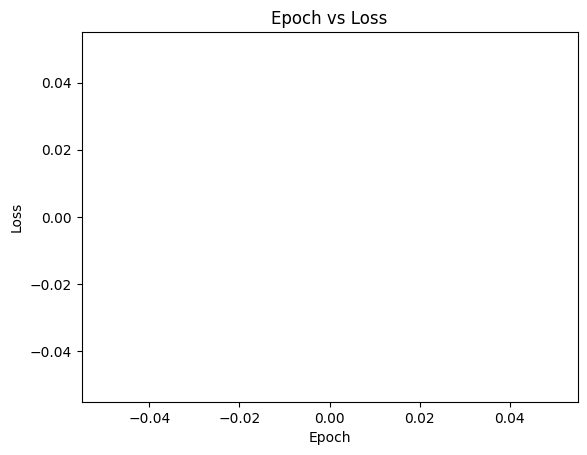

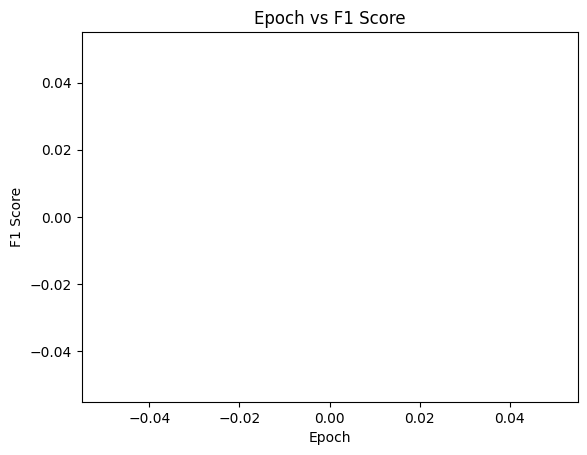

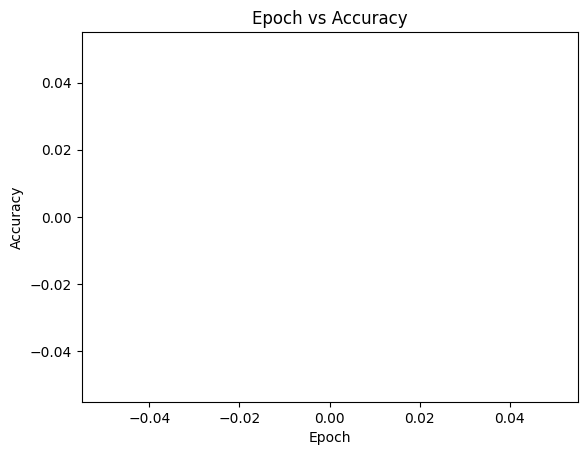

In [10]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Epoch vs Loss')
plt.show()

# Plot f1
plt.plot(train_f1, label="Train F1")
plt.plot(val_f1, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title('Epoch vs F1 Score')
plt.show()

# Plot Accuracy
plt.plot(train_f1, label="Train Acc")
plt.plot(val_f1, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Epoch vs Accuracy')
plt.show()


## Submitting Your Results
Once you have successfully trained your model, generate predictions on the test set and save your results as a `.csv` file. This file can then be uploaded to the leaderboard.

Your final `.csv` file **must** have the following format:
- There must be a column titled `image_path` with the paths to the test set images. This column should be identical to the one provided in `mimic_test_student.csv`.
- There must be a column titled `pred` with your model outputs.
  - If you are running the `distance categorization` task, this column must have floating point numbers ranging between 0 and 1. Higher numbers should indicate a greater likelihood that the tube distance is abnormal. Hint: You can convert model outputs to the 0 to 1 range by applying the sigmoid activation function (torch.nn.sigmoid())
  - If you are running the `distance prediction` task, this column must have numbers representing the tube distance in centimeters.
- Double check that there are 500 rows in your output file

In [14]:

resnet50_exp1 = models.resnet50(weights="ResNet50_Weights.DEFAULT")
n_features = resnet50_exp1.fc.in_features
resnet50_exp1.fc = nn.Sequential(
    nn.Linear(n_features, n_features),
    nn.Dropout(p=0.5),
    nn.Linear(n_features, n_features),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(n_features, 1),
)

resnet50_exp5 = models.resnet50(weights="ResNet50_Weights.DEFAULT")
n_features = resnet50_exp5.fc.in_features
resnet50_exp5.fc = nn.Sequential(
    nn.Linear(n_features, n_features),
    nn.ReLU(),
    nn.Linear(n_features, 1),
)

for i, child in enumerate(resnet50_exp5.children()):
  if i == 9:
    for param in child.parameters():
        param.requires_grad = True
    break
  for param in child.parameters():
        param.requires_grad = False

resnet50_exp6 = models.resnet50(weights="ResNet50_Weights.DEFAULT")
n_features = resnet50_exp6.fc.in_features
resnet50_exp6.fc = nn.Sequential(
    nn.Linear(n_features, n_features),
    nn.Dropout(p=0.5),
    nn.Linear(n_features, n_features),
    nn.ReLU(),
    nn.Linear(n_features, 1),
)

for i, child in enumerate(resnet50_exp6.children()):
  for param in child.parameters():
        param.requires_grad = True

model_exp1 = torch.load("/content/drive/MyDrive/kams_colab/resnet50_tl_exp_1_epoch_25.pth")
resnet50_exp1.load_state_dict(model_exp1["model_state_dict"])
print(model_exp1["val_acc"][-1])
print(model_exp1['val_f1'][-1])
resnet50_exp1.to(device).eval()

model_exp5 = torch.load("/content/drive/MyDrive/kams_colab/resnet50_tl_exp_5_epoch_6.pth")
resnet50_exp5.load_state_dict(model_exp5["model_state_dict"])
print(model_exp5["val_acc"][-1])
print(model_exp5['val_f1'][-1])
resnet50_exp5.to(device).eval()

model_exp6 = torch.load("/content/drive/MyDrive/kams_colab/resnet50_tl_exp_6_epoch_28.pth")
resnet50_exp6.load_state_dict(model_exp6["model_state_dict"])
print(model_exp6["val_acc"][-1])
print(model_exp6['val_f1'][-1])
resnet50_exp6.to(device).eval()

test_set = pd.read_csv("/content/drive/MyDrive/kams_colab/mimic_test_student.csv")
test_set = test_set.drop(columns=["Unnamed: 0", "split", "patient_id", "study_id", "image_id"])


class TestDataset(Dataset):
    def __init__(self, img_path):
        super(TestDataset, self).__init__()
        self.img_paths = img_paths
        # Fill in __init__() here

    def __len__(self):

        # Fill in __len__() here
        return self.img_paths.shape[0]

    def __getitem__(self, idx):
        out_dict = {"idx": torch.tensor(idx),}

        # Fill in __getitem__() here
        im = Image.open(f"/content/{self.img_paths[idx]}")

        w, h = im.size
        ima = Image.new('RGB', (w,h))
        data = zip(im.getdata(), im.getdata(), im.getdata())
        ima.putdata(list(data))
        convert_tensor = transforms.Compose([
            transforms.Resize(size=224),
            transforms.ToTensor(),
        ])

        img_as_tensor = convert_tensor(ima)
        img_as_tensor.requires_grad_ = True
        out_dict["img"] = img_as_tensor

        return out_dict






Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


0.7152777777777778
0.8306299453904723
0.7152777777777778
0.8023694751137251
0.7447916666666666
0.8462208445837909
0.7725694444444444
0.8453939954955793


In [16]:
test_image_paths = test_set["image_path"].to_numpy()
# test_dataset = TestDataset(img_path=test_image_paths)
# test_loader = DataLoader(dataset=test_dataset, batch_size=25, shuffle=True, drop_last=False)
inputs = []
def transform_image(path):
   # Fill in __getitem__() here
    im = Image.open(f"/content/{path}")

    w, h = im.size
    ima = Image.new('RGB', (w,h))
    data = zip(im.getdata(), im.getdata(), im.getdata())
    ima.putdata(list(data))
    convert_tensor = transforms.Compose([
        transforms.Resize(size=224),
        transforms.ToTensor(),
    ])

    img_as_tensor = convert_tensor(ima)
    img_as_tensor.requires_grad_ = True
    return img_as_tensor

preds = []
for path in test_image_paths:
  input = transform_image(path).to(device)
  input = input.unsqueeze(0).to(device)
  out1 = resnet50_exp5(input)
  out2 = resnet50_exp6(input)
  out3 = resnet50_exp1(input)

  prob1 = torch.sigmoid(out1[0]).detach().cpu().numpy()
  prob2 = torch.sigmoid(out2[0]).detach().cpu().numpy()
  prob3 = torch.sigmoid(out3[0]).detach().cpu().numpy()
  avg = (prob1 + prob2 + prob3) / 4
  # res = res.detach().cpu().numpy()
  res = 1 - avg[0]
  preds.append(res)

test_set["pred"] = preds

test_set


,image_path,pred
0,mimic-test/10345/50410/80276.jpg,0.179463
1,mimic-test/10345/50232/80350.jpg,0.174063
2,mimic-test/10189/50388/80353.jpg,0.189505
3,mimic-test/10127/50441/80124.jpg,0.254442
4,mimic-test/10004/50475/80218.jpg,0.176429
...,...,...
495,mimic-test/10252/50003/80193.jpg,0.175600
496,mimic-test/10363/50408/80072.jpg,0.270861
497,mimic-test/10363/50145/80039.jpg,0.328181
498,mimic-test/10054/50265/80374.jpg,0.104668


In [17]:

test_set.to_csv(f"/content/drive/MyDrive/kams_colab/test_results_exp5_and_exp6_and_exp1_and_inc.csv")